<div style="font-size:110%">

In this notebook, we apply the following methods:  
1. Optimal Rank-\(k\) SVD, 
2. Embedding Dot-Product Model
3. Iterative SVD, 
4. SVD\++, 
5. NeuMF
6. GraphNeuMF, 
7. DMF 
8. Ensemble strategies (simple average, weighted average, top-\(k\) weighted, deep stacking).

</div>

In [24]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Tuple, Callable

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from torch_geometric.nn import LGConv
from torch_sparse import SparseTensor

# Constants
DATA_DIR = ""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [26]:
def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data and splits it into training and validation sets with a 75/25 split."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    
    # Split into train and validation dataset
    train_df, valid_df = train_test_split(df, test_size=0.1)
    return train_df, valid_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data, where columns are scientists (sid) and
    rows are papers (pid)."""

    return df.pivot(index="sid", columns="pid", values="rating").values


def read_wishlist_df() -> pd.DataFrame:
    """Reads in the wishlist data (train_tbr.csv)."""
    
    tbr_df = pd.read_csv(os.path.join(DATA_DIR, "train_tbr.csv"))
    # Ensure sid and pid are integers
    tbr_df["sid"] = tbr_df["sid"].astype(int)
    tbr_df["pid"] = tbr_df["pid"].astype(int)
    return tbr_df


def read_wishlist_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the wishlist data.
    Rows are scientists (sid), columns are papers (pid).
    Values are 1 if the paper is on the wishlist, NaN otherwise."""
    
    # Add a temporary column with value 1 for pivoting
    df_copy = df.copy()
    df_copy['wishlisted'] = 1


    all_sids = pd.Index(range(10000))
    wishlist_matrix = df_copy.pivot(index="sid", columns="pid", values="wishlisted")
    wishlist_matrix = wishlist_matrix.reindex(all_sids)

    return wishlist_matrix.values

def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

In [27]:
def impute_values(mat: np.ndarray) -> np.ndarray:
    """Fills in missing values of the matrix"""
    return np.nan_to_num(mat, nan=3.0)

In [28]:
train_ratings_df, valid_ratings_df = read_data_df()
train_wishlist_df = read_wishlist_df()

train_mat = read_data_matrix(train_ratings_df)
train_mat = impute_values(train_mat)

train_wishlist_mat = read_wishlist_matrix(train_wishlist_df)

## Method 1: Low-Rank SVD Approximation

Next, we take a linear algebra view of the researcher–paper matrix \(M\) by computing its SVD:

$$
M = U \,\Sigma\,V^T
$$

We then truncate to the top \(k\) singular components:

$$
U_k = U[:, :k], \quad \Sigma_k = \Sigma_{1:k}, \quad V_k^T = V^T[:k, :]
$$

to form the low-rank reconstruction

$$
M_k = U_k \,\Sigma_k\,V_k^T
$$

Finally, we score any researcher–paper pair \((r,p)\) by indexing into \(M_k\):

$$
\hat r_{rp} = (M_k)_{r,p}
$$


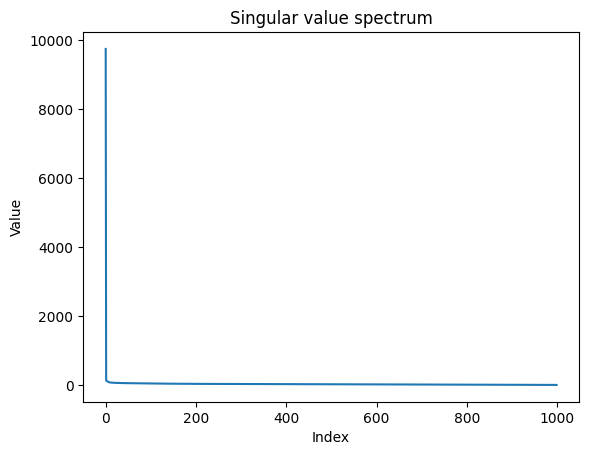

In [29]:
singular_values = np.linalg.svd(train_mat, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()

We reduce the researcher–paper matrix to its top-k singular components to capture the most important interaction patterns. Then we provide a simple lookup function that fetches the predicted score for any researcher–paper pair from this compressed representation.  


In [30]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

We compute a rank-2 low-rank approximation of the training matrix via SVD by calling `opt_rank_k_approximation(train_mat, k=2)`.  


In [ ]:
train_recon = opt_rank_k_approximation(train_mat, k=2)

In [32]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_ratings_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.186


## Method 2: Learned embeddings

Next, we will take a machine learning view of the problem. To each scientist and paper, we assign a $d$-dimensional embedding and we predict the rating that the scientist gives the paper to be their dot product. More formally, let $\vec{s}_i$ be a scientist embedding and $\vec{p}_j$ be a paper embedding. Then, we make the following rating prediction for this pair: $$\tilde{r}_{ij} = \langle \vec{s}_i, \vec{p}_j \rangle.$$ We view these embeddings as our learnable parameters and train them as we would any other model using the squared error loss function: $$\ell(\theta) = \frac{1}{2} |\langle \vec{s}_i, \vec{p}_j \rangle - r_{ij}|^2,$$ where $\theta = \{ \vec{s}_i \}_{i=1}^n \cup \{ \vec{p}_j \}_{j=1}^m$. The following is an implementation of this method.

In [33]:
class EmbeddingDotProductModel(nn.Module):
    def __init__(self, num_scientists: int, num_papers: int, dim: int):
        super().__init__()

        # Assign to each scientist and paper an embedding
        self.scientist_emb = nn.Embedding(num_scientists, dim)
        self.paper_emb = nn.Embedding(num_papers, dim)
        
    def forward(self, sid: torch.Tensor, pid: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
            sid: [B,], int
            pid: [B,], int
        
        Outputs: [B,], float
        """

        # Per-pair dot product
        return torch.sum(self.scientist_emb(sid) * self.paper_emb(pid), dim=-1)

In [34]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
model = EmbeddingDotProductModel(10_000, 1_000, 64).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

We convert the Pandas DataFrames into PyTorch `TensorDataset`s containing researcher IDs, paper IDs, and ratings for easy batching. 

We then create `DataLoader`s with batch size 64—shuffled for training and sequential for validation—to feed data into our models.  


In [35]:
def get_dataset(df: pd.DataFrame):
    sids = torch.tensor(df["sid"].values, dtype=torch.long)
    pids = torch.tensor(df["pid"].values, dtype=torch.long)
    ratings = torch.tensor(df["rating"].values, dtype=torch.float32)
    return torch.utils.data.TensorDataset(sids, pids, ratings)

train_dataset = get_dataset(train_ratings_df)
valid_dataset = get_dataset(valid_ratings_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)


We train the model for $5$ epochs over researcher–paper batches, minimizing MSE and updating parameters via backpropagation, but the training loss isn’t improving substantially. 

We’ll need to explore other more advanced techniques to boost performance.  


In [36]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss, total_count = 0.0, 0
    for sid, pid, ratings in train_loader:
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        preds = model(sid, pid)
        loss = F.mse_loss(preds, ratings)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item() * len(sid)
        total_count += len(sid)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {total_loss / total_count:.4f}")

[Epoch 1/5] Train Loss: 53.4843
[Epoch 2/5] Train Loss: 19.9365
[Epoch 3/5] Train Loss: 3.3771
[Epoch 4/5] Train Loss: 1.2094
[Epoch 5/5] Train Loss: 0.9402


In [37]:
pred_fn = lambda sids, pids: model(torch.from_numpy(sids).to(device), torch.from_numpy(pids).to(device))

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_ratings_df, pred_fn)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.042


## Method 3: Iterative SVD Imputation

We start with the incomplete researcher–paper matrix \(M\), fill missing entries with initial estimates to get \(M^{(0)}\), and then repeat:

Compute truncated SVD on the current matrix:
   $$
   M^{(t-1)} = U\,\Sigma\,V^T,
   \qquad
   M_k^{(t)} = U_k\,\Sigma_k\,V_k^T
   $$

Update only the missing entries:
   $$
   M^{(t)}_{ij} =
   \begin{cases}
   M_{ij}, & \text{if }(i,j)\text{ observed},\\
   \bigl(M_k^{(t)}\bigr)_{ij}, & \text{if }(i,j)\text{ missing}.
   \end{cases}
   $$

Measure change on the missing entries:
   $$
   \Delta^{(t)} = \bigl\|\,\bigl(M_k^{(t)}\bigr)_{\text{missing}} \;-\; M^{(t-1)}_{\text{missing}} \bigr\|_2
   $$

We stop when \(\Delta^{(t)}\) falls below the tolerance, and then use the final matrix \(M^{(*)}\) to score researcher–paper pairs by simple indexing.


In [38]:
def iterative_svd(df, k=2, max_iterations=10, tolerance=0.001):
    mat = read_data_matrix(df)
    missing_mask = np.isnan(mat)
    imputed_mat = impute_values(mat)

    for iteration in range(max_iterations):
        previous_mat = imputed_mat.copy()
        reconstructed_mat = opt_rank_k_approximation(imputed_mat, k)

        imputed_mat = mat.copy()
        imputed_mat[missing_mask] = reconstructed_mat[missing_mask]

        diff = np.linalg.norm(reconstructed_mat[missing_mask] - previous_mat[missing_mask])
        print(f"Iteration {iteration + 1}, Change: {diff:.6f}")

        if diff < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break

    return imputed_mat


We choose $k=2$ to capture the two most significant latent factors, set `max_iterations=200` for sufficient refinement, and use a tolerance of $10^{-4}$ to ensure stable convergence.  


In [39]:
final_mat = iterative_svd(train_ratings_df, k=2, max_iterations=200, tolerance=0.0001)

Iteration 1, Change: 358.604161
Iteration 2, Change: 281.641703
Iteration 3, Change: 229.566501
Iteration 4, Change: 192.320822
Iteration 5, Change: 164.490904
Iteration 6, Change: 142.951880
Iteration 7, Change: 125.801054
Iteration 8, Change: 111.826364
Iteration 9, Change: 100.224236
Iteration 10, Change: 90.442575
Iteration 11, Change: 82.089858
Iteration 12, Change: 74.880570
Iteration 13, Change: 68.601350
Iteration 14, Change: 63.089309
Iteration 15, Change: 58.217755
Iteration 16, Change: 53.886528
Iteration 17, Change: 50.015309
Iteration 18, Change: 46.538876
Iteration 19, Change: 43.403681
Iteration 20, Change: 40.565323
Iteration 21, Change: 37.986667
Iteration 22, Change: 35.636408
Iteration 23, Change: 33.487973
Iteration 24, Change: 31.518657
Iteration 25, Change: 29.708947
Iteration 26, Change: 28.041987
Iteration 27, Change: 26.503140
Iteration 28, Change: 25.079641
Iteration 29, Change: 23.760309
Iteration 30, Change: 22.535311
Iteration 31, Change: 21.395969
Iteratio

In [40]:
pred_iter_svd = lambda sids, pids: matrix_pred_fn(final_mat, sids, pids).flatten()

val_score = evaluate(valid_ratings_df, pred_iter_svd)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.875


The validation performance is just enough to pass the simple baseline, so we will now explore advanced neural methods like NeuMF, DMF, or hybrid combinations of both to improve recommendation accuracy.  


## Method 4: SVD++

We extend basic matrix factorization by adding user/item biases and modeling implicit feedback. Each researcher $r$ and paper $p$ has embeddings $\mathbf{p}_r,\mathbf{q}_p\in\mathbb{R}^d$, biases $b_r,b_p\in\mathbb{R}$, and implicit-feedback embeddings $\{y_j\}$. We predict

$$
\hat r_{rp} = \mu + b_r + b_p + \mathbf{q}_p^T\Bigl(\mathbf{p}_r + \frac{1}{\sqrt{|\mathcal{N}(r)|}}\sum_{j\in\mathcal{N}(r)} y_j\Bigr),
$$

where $\mu$ is the global mean and $\mathcal{N}(r)$ is the set of papers researcher $r$ has interacted with. We train all parameters by minimizing the squared error loss

$$
\ell(\theta) = \frac12\bigl(\hat r_{rp} - r_{rp}\bigr)^2.
$$

In [41]:
class SVDPP(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.implicit_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=num_items)  # Padding index = num_items
        self.global_mean = nn.Parameter(torch.tensor(3.0), requires_grad=False)

    def forward(self, user_ids, item_ids, implicit_items):
        p_u = self.user_emb(user_ids)
        q_i = self.item_emb(item_ids)
        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()

        mask = (implicit_items != self.implicit_emb.padding_idx).unsqueeze(-1)
        y_j = self.implicit_emb(implicit_items) * mask
        norm = torch.sqrt(mask.sum(dim=1).clamp(min=1).float())
        implicit_sum = y_j.sum(dim=1) / norm

        x_u = p_u + implicit_sum
        dot = (x_u * q_i).sum(dim=1)

        return self.global_mean + b_u + b_i + dot

We instantiate the SVD++ model for $10\,000$ researchers and $1\,000$ papers, each represented in a $16$-dimensional embedding space to capture diverse latent factors.

The Adam optimizer is configured with a learning rate of $10^{-3}$ and an L2 weight decay of $10^{-4}$ to balance rapid learning with regularization.

A ReduceLROnPlateau scheduler monitors the validation loss and, if it does not improve for one epoch, halves the learning rate to allow finer-grained updates and more stable convergence.


In [42]:
model_svdpp = SVDPP(num_users=10_000, num_items=1_000, emb_dim=16).to(device)
optim_svdpp = torch.optim.Adam(model_svdpp.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_svdpp, mode='min', factor=0.5, patience=1)

We create a fixed-size implicit-feedback matrix where each of the 10 000 researchers is assigned a list of up to 50 papers they have interacted with.  

Using a `defaultdict`, we first collect all paper IDs for each researcher. We then build a NumPy array of shape (10 000, 50), filling unused slots with a padding index equal to the number of items.  

Finally, we convert this array into a PyTorch tensor on the target device so it can be fed directly into the SVD++ model as implicit feedback.  


In [43]:
from collections import defaultdict

def build_implicit_item_matrix(df, num_users, num_items, max_len=50):
    PAD_IDX = num_items
    user_implicit = defaultdict(list)
    for _, row in df.iterrows():
        user_implicit[int(row['sid'])].append(int(row['pid']))
    matrix = np.full((num_users, max_len), fill_value=PAD_IDX, dtype=int)
    for user_id, items in user_implicit.items():
        matrix[user_id, :min(len(items), max_len)] = items[:max_len]
    return torch.tensor(matrix, dtype=torch.long)

NUM_USERS = 10_000
NUM_ITEMS = 1_000
EMB_DIM = 16
MAX_LEN = 50

implicit_matrix = build_implicit_item_matrix(train_ratings_df, NUM_USERS, NUM_ITEMS, max_len=MAX_LEN).to(device)

Over 10 epochs, we alternate between training and validation.  

During training, for each batch of researcher–paper pairs we mask out the current paper from the researcher’s implicit list, predict ratings with SVD++, compute MSE loss, and update parameters via Adam.  

In validation, we again mask the held‐out paper, compute predictions without gradient updates, and aggregate the squared errors to report RMSE.  

A ReduceLROnPlateau scheduler adjusts the learning rate based on the validation loss for more stable convergence.  


In [44]:
# Cell 4: Training and Validation Loop with Masking Current Item and RMSE Logging
NUM_EPOCHS = 10
PAD_IDX = model_svdpp.implicit_emb.padding_idx

for epoch in range(NUM_EPOCHS):
    model_svdpp.train()
    train_loss_total, train_count = 0.0, 0
    for sid, pid, ratings in train_loader:
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # clone and mask out current item from implicit feedback
        imp_items = implicit_matrix[sid].clone()
        imp_items[imp_items == pid.unsqueeze(1)] = PAD_IDX

        preds = model_svdpp(sid, pid, imp_items)
        loss = F.mse_loss(preds, ratings)

        optim_svdpp.zero_grad()
        loss.backward()
        optim_svdpp.step()

        train_loss_total += loss.item() * sid.size(0)
        train_count += sid.size(0)

    avg_train_loss = train_loss_total / train_count

    model_svdpp.eval()
    val_mse_total, val_count = 0.0, 0
    with torch.no_grad():
        for sid, pid, ratings in valid_loader:
            sid = sid.to(device)
            pid = pid.to(device)
            ratings = ratings.to(device)

            imp_items = implicit_matrix[sid].clone()
            imp_items[imp_items == pid.unsqueeze(1)] = PAD_IDX

            preds = model_svdpp(sid, pid, imp_items)
            mse = F.mse_loss(preds, ratings, reduction='sum')

            val_mse_total += mse.item()
            val_count += sid.size(0)

    valid_rmse = (val_mse_total / val_count) ** 0.5
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} – Train Loss: {avg_train_loss:.4f}, Valid RMSE: {valid_rmse:.4f}")
    scheduler.step(val_mse_total / val_count)


Epoch 1/10 – Train Loss: 9.9278, Valid RMSE: 1.3532
Epoch 2/10 – Train Loss: 1.0362, Valid RMSE: 0.9103
Epoch 3/10 – Train Loss: 0.7914, Valid RMSE: 0.8869
Epoch 4/10 – Train Loss: 0.7730, Valid RMSE: 0.8815
Epoch 5/10 – Train Loss: 0.7670, Valid RMSE: 0.8799
Epoch 6/10 – Train Loss: 0.7639, Valid RMSE: 0.8788
Epoch 7/10 – Train Loss: 0.7626, Valid RMSE: 0.8787
Epoch 8/10 – Train Loss: 0.7610, Valid RMSE: 0.8788
Epoch 9/10 – Train Loss: 0.7602, Valid RMSE: 0.8778
Epoch 10/10 – Train Loss: 0.7595, Valid RMSE: 0.8782


In [45]:
pred_fn_svdpp = lambda sids, pids: model_svdpp(
    torch.from_numpy(sids).to(device),
    torch.from_numpy(pids).to(device),
    implicit_matrix[
        torch.from_numpy(np.clip(sids, 0, implicit_matrix.shape[0] - 1)).to(device)
    ]
).detach().cpu().numpy()

with torch.no_grad():
    val_score = evaluate(valid_ratings_df, pred_fn_svdpp)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.878


After training, we achieved a validation RMSE of 0.878, which again only just beats our simple baseline. 

However, SVD++ allowed extensive hyperparameter tuning—embedding size, learning rate, weight decay, and scheduler settings—and the current configuration represents the best combination we found. This fine-tuning flexibility, along with the model’s ability to incorporate both biases and implicit feedback, makes SVD++ preferable to the more rigid iterative SVD approach. Additional advantages include faster convergence on sparse data and a straightforward path to extend with dropout or deeper bias structures if needed.  


### Note: Wishlist Data Incorporation

From this point, we incorporate the wishlist information by passing both the ratings DataFrame (with columns `sid`, `pid`, `rating`) and the wishlist DataFrame (with columns `sid`, `pid`) into `get_dataset`. Inside the function, we first tag every wishlist entry with `wishlist = 1.0` and then perform a **full outer join** on `(sid, pid)`, ensuring that any researcher–paper pair present in either list appears exactly once. After merging, we fill missing `rating` or `wishlist` values with `0.0` (indicating no explicit rating or no wishlist flag), convert each column into a PyTorch tensor, and pack them into a `TensorDataset` of `(sid, pid, rating, wishlist_flag)` for downstream training.  


In [83]:
def get_dataset(
    df: pd.DataFrame,
    wishlist_df: pd.DataFrame = None
) -> torch.utils.data.Dataset:
    """
    Returns a dataset of (sid, pid, rating, wishlist_flag) for every
    (sid,pid) in ratings OR wishlist.  Missing ratings or wishlist
    entries are filled with 0.0.
    """
    # If no wishlist provided, just add an empty wishlist column
    if wishlist_df is None:
        merged = df.copy()
        merged['wishlist'] = 0.0

    else:
        w = wishlist_df[['sid', 'pid']].copy()
        w['wishlist'] = 1.0

        merged = pd.merge(
            df[['sid', 'pid', 'rating']],
            w,
            on=['sid', 'pid'],
            how='outer'       # <-- full join
        )

        merged['rating'] = merged['rating'].fillna(0.0)
        merged['wishlist'] = merged['wishlist'].fillna(0.0)

    sids      = torch.from_numpy(merged['sid'].to_numpy()).long()
    pids      = torch.from_numpy(merged['pid'].to_numpy()).long()
    ratings   = torch.from_numpy(merged['rating'].to_numpy()).float()
    wishlists = torch.from_numpy(merged['wishlist'].to_numpy()).float()

    return torch.utils.data.TensorDataset(sids, pids, ratings, wishlists)

## Method 5: Neural Matrix Factorization (NeuMF)

We build a hybrid model that learns both linear and nonlinear interactions and jointly predicts ratings and wishlist preferences. NeuMF combines a GMF branch (element-wise product of embeddings) with an MLP branch (deep concatenation of embeddings), fuses them via a learned weight $\alpha$, and uses separate output heads for rating and wishlist signals.

---

**Detailed Architecture**

- **Input embeddings**  
  Each researcher $r$ and paper $p$ has a $d$-dimensional embedding $\mathbf{u}_r,\mathbf{v}_p\in\mathbb{R}^d$.

- **GMF branch**  
  $$g = \mathbf{u}_r \odot \mathbf{v}_p$$

- **MLP branch**  
  Concatenate and feed through hidden layers:  
  $$
  x^{(1)} = [\mathbf{u}_r, \mathbf{v}_p],\quad
  x^{(\ell+1)} = \mathrm{GELU}(W^{(\ell)} x^{(\ell)} + b^{(\ell)}),\;\ell=1,\dots,L
  $$
  yielding $m = x^{(L+1)}$.

- **Fusion**  
  $$f = [\,\alpha\,g,\;(1-\alpha)\,m\,],\quad \alpha\in[0,1]\ \text{learned}$$

- **Output heads**  
  - **Rating**:  
    $$\hat r = 1 + 4\;\sigma\bigl(W_r\,f + b_r\bigr),$$  
    constraining $\hat r\in[1,5]$.  
  - **Wishlist**:  
    $$\hat w = \sigma\bigl(W_w\,f + b_w\bigr),\quad \hat w\in[0,1].$$

- **Loss function**  
  Combine rating MSE (only where no wishlist) and wishlist MSE:  
  $$
  \ell = \frac{1}{2}\|\hat r - r\|^2_{\!(w=0)} \;+\;\lambda\,\|\hat w - w\|^2,
  $$  
  where $\|\cdot\|_{(w=0)}$ masks out entries with $w=1$, and $\lambda$ is the wishlist weight.

This design lets NeuMF capture both simple latent-factor signals and high-order nonlinear interactions, simultaneously optimizing for two complementary tasks.  


In [47]:
class GMF(nn.Module):
    def __init__(self, num_researchers, num_papers, emb_dim):
        super().__init__()
        self.researcher_emb = nn.Embedding(num_researchers, emb_dim)
        self.paper_emb = nn.Embedding(num_papers, emb_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, researcher_indices, paper_indices):
        r = self.dropout(self.researcher_emb(researcher_indices))
        p = self.dropout(self.paper_emb(paper_indices))
        return r * p

class MLP(nn.Module):
    def __init__(self, num_researchers, num_papers, emb_dim, mlp_layers):
        super().__init__()
        self.researcher_emb = nn.Embedding(num_researchers, emb_dim)
        self.paper_emb = nn.Embedding(num_papers, emb_dim)
        self.dropout = nn.Dropout(0.2)
        layers = []
        input_size = emb_dim * 2
        for h in mlp_layers:
            layers += [nn.Linear(input_size, h), nn.GELU(), nn.Dropout(0.2)]
            input_size = h
        self.mlp = nn.Sequential(*layers)

    def forward(self, researcher_indices, paper_indices):
        r = self.dropout(self.researcher_emb(researcher_indices))
        p = self.dropout(self.paper_emb(paper_indices))
        x = torch.cat([r, p], dim=1)
        return self.mlp(x)

class NeuMF(nn.Module):
    def __init__(self, num_researchers, num_papers, emb_dim, mlp_layers, wishlist_weight=2.0):
        super().__init__()
        self.gmf = GMF(num_researchers, num_papers, emb_dim)
        self.mlp = MLP(num_researchers, num_papers, emb_dim, mlp_layers)
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.wishlist_weight = wishlist_weight

        final_size = emb_dim + mlp_layers[-1]
        self.fc_rating = nn.Linear(final_size, 1)
        self.fc_wishlist = nn.Linear(final_size, 1)

    def forward(self, researcher_indices, paper_indices):
        g = self.gmf(researcher_indices, paper_indices)
        m = self.mlp(researcher_indices, paper_indices)
        fused = torch.cat([self.alpha * g, (1 - self.alpha) * m], dim=1)
        rating = 1 + 4 * torch.sigmoid(self.fc_rating(fused).squeeze(1))
        wishlist = torch.sigmoid(self.fc_wishlist(fused).squeeze(1))
        return rating, wishlist

    def calc_loss(self, rating_pred, rating_target, wishlist_pred, wishlist_target):
        # Only compute rating loss where wishlist_target is 0
        mask = wishlist_target == 0
        rating_loss = F.mse_loss(rating_pred[mask], rating_target[mask])
        wishlist_loss = F.mse_loss(wishlist_pred, wishlist_target)
        return rating_loss + self.wishlist_weight * wishlist_loss

In [48]:
train_dataset = get_dataset(train_ratings_df, train_wishlist_df)
valid_dataset = get_dataset(valid_ratings_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

We configure the NeuMF model with $10,000$ researchers and $1,000$ papers, embedding each into a $16$-dimensional latent space and using two MLP hidden layers of size $32$.  

The wishlist loss is weighted by $2.0$, and training runs for $40$ epochs with batch size $64$, using AdamW at learning rate $5\times10^{-3}$ and L2 regularization; a ReduceLROnPlateau scheduler halves the learning rate if validation loss does not improve for one epoch.  

In [49]:
NUM_USERS = 10_000
NUM_ITEMS = 1_000
EMB_DIM = 16
MLP_HIDDEN = [32, 32]
WISHLIST_LOSS_WEIGHT = 2.0
BATCH_SIZE = 64
NUM_EPOCHS = 40
LEARNING_RATE = 5e-3

model_neumf = NeuMF(NUM_USERS, NUM_ITEMS, EMB_DIM, MLP_HIDDEN, WISHLIST_LOSS_WEIGHT).to(device)
optimizer = torch.optim.AdamW(model_neumf.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

The NeuMF training loop mirrors the SVD++ procedure: over $40$ epochs we perform forward/backward passes with AdamW on each batch’s ratings and wishlist flags, then compute validation RMSE (clamping ratings to $[1,5]$) and step the ReduceLROnPlateau scheduler.  


In [50]:
NUM_EPOCHS = 40
for epoch in range(NUM_EPOCHS):
    model_neumf.train()
    running_loss = 0.0

    for sid, pid, ratings, wishlists in train_loader:
        sid, pid = sid.to(device), pid.to(device)
        ratings, wishlists = ratings.to(device), wishlists.to(device)

        pred_ratings, pred_wishlist = model_neumf(sid, pid)
        loss = model_neumf.calc_loss(pred_ratings, ratings, pred_wishlist, wishlists)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * sid.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model_neumf.eval()
    mse_total = 0.0
    with torch.no_grad():
        for sid, pid, ratings, _ in valid_loader:
            sid, pid = sid.to(device), pid.to(device)
            ratings = ratings.to(device)

            pred_ratings, _ = model_neumf(sid, pid)
            mse = F.mse_loss(pred_ratings.clamp(1, 5), ratings)
            mse_total += mse.item() * sid.size(0)

    rmse = (mse_total / len(valid_loader.dataset)) ** 0.5
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} – Train Loss: {avg_train_loss:.4f}, Valid RMSE: {rmse:.4f}")
    scheduler.step(rmse)

Epoch 1/40 – Train Loss: 1.2049, Valid RMSE: 0.9039
Epoch 2/40 – Train Loss: 1.1356, Valid RMSE: 0.9056
Epoch 3/40 – Train Loss: 1.1269, Valid RMSE: 0.8964
Epoch 4/40 – Train Loss: 1.1112, Valid RMSE: 0.8905
Epoch 5/40 – Train Loss: 1.0988, Valid RMSE: 0.8889
Epoch 6/40 – Train Loss: 1.0920, Valid RMSE: 0.8867
Epoch 7/40 – Train Loss: 1.0842, Valid RMSE: 0.8854
Epoch 8/40 – Train Loss: 1.0792, Valid RMSE: 0.8851
Epoch 9/40 – Train Loss: 1.0761, Valid RMSE: 0.8812
Epoch 10/40 – Train Loss: 1.0736, Valid RMSE: 0.8848
Epoch 11/40 – Train Loss: 1.0736, Valid RMSE: 0.8797
Epoch 12/40 – Train Loss: 1.0719, Valid RMSE: 0.8822
Epoch 13/40 – Train Loss: 1.0705, Valid RMSE: 0.8792
Epoch 14/40 – Train Loss: 1.0701, Valid RMSE: 0.8748
Epoch 15/40 – Train Loss: 1.0704, Valid RMSE: 0.8779
Epoch 16/40 – Train Loss: 1.0691, Valid RMSE: 0.8768
Epoch 17/40 – Train Loss: 1.0231, Valid RMSE: 0.8610
Epoch 18/40 – Train Loss: 1.0144, Valid RMSE: 0.8617
Epoch 19/40 – Train Loss: 1.0161, Valid RMSE: 0.8620
Ep

In [51]:
os.makedirs("models", exist_ok=True)
torch.save(model_neumf.state_dict(), "models/neumf.pt")
print("Model saved to models/neumf.pt")

Model saved to models/neumf.pt


In [52]:
pred_fn_neumf = lambda sids, pids: model_neumf(
    torch.from_numpy(sids).to(device),
    torch.from_numpy(pids).to(device)
)[0].clamp(1, 5).detach().cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_ratings_df, pred_fn_neumf)

print(f"Validation RMSE: {val_score:.3f}")


Validation RMSE: 0.848


The NeuMF model outperformed our previous baselines—marking the first time we beat the hard benchmark—with surprisingly strong validation results.

Achieving this required extensive tuning: we set the wishlist loss weight to $2.0$ (since MSE is less severe than binary cross-entropy, allowing a coefficient higher than 1), kept embedding and hidden layer sizes modest to prevent overfitting, and applied a relatively high weight decay $\lambda$ for regularization. Too large a decay would prevent the model from learning (training loss wouldn’t decrease), so this configuration yielded the best overall performance.  


## Method 6: Graph-Augmented NeuMF (GraphNeuMF)

We model researcher–paper interactions as a bipartite graph to propagate information across similar nodes. Let \(A\) be the adjacency matrix and \(\tilde D\) its degree matrix; LightGCN refines initial embeddings \(X^{(0)}\) via

$$
X^{(l+1)} = \tilde D^{-1}A\,X^{(l)},\qquad l = 0,\dots,L-1,
$$

and aggregates them into

$$
X = \frac{1}{L+1}\sum_{l=0}^L X^{(l)}.
$$

After pretraining with a BPR loss to separate positive and negative edges, we extract the user and paper rows of \(X\) and fuse them with GMF’s elementwise product and MLP’s encoding into a combined vector \(f\). Two output heads then compute:

- **Rating**  
  $$
  \hat r = 1 + 4\,\sigma\bigl(W_r f + b_r\bigr),
  $$

- **Wishlist**  
  $$
  \hat w = \sigma\bigl(W_w f + b_w\bigr).
  $$

We train both tasks with mean-squared error, weighting the wishlist term by \(\lambda_{\text{wish}}\):

$$
\ell = \mathrm{MSE}(\hat r, r)
\;+\;
\lambda_{\text{wish}}\;\mathrm{MSE}(\hat w, w).
$$  


In [84]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, num_layers=3):
        super().__init__()
        self.num_users  = num_users
        self.num_items  = num_items
        self.emb_dim    = emb_dim
        self.num_layers = num_layers

        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

        # graph convolution layers
        from torch_geometric.nn import LGConv
        self.convs = nn.ModuleList([
            LGConv(normalize=True) for _ in range(num_layers)
        ])

        # will hold a SparseTensor
        self.adj = None

    def set_adj(self, edge_index: torch.LongTensor, device: torch.device):
        # build and store the adjacency once
        self.adj = SparseTensor(
            row=edge_index[0],
            col=edge_index[1] + self.num_users,
            sparse_sizes=(self.num_users + self.num_items,) * 2
        ).to(device)

    def forward(self):
        x = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embeddings = [x]

        for conv in self.convs:
            x = conv(x, self.adj)
            embeddings.append(x)

        x = torch.mean(torch.stack(embeddings), dim=0)
        user_emb, item_emb = torch.split(x, [self.num_users, self.num_items])
        return user_emb, item_emb

    def get_embeddings(self, user_idx, item_idx):
        return self.user_emb(user_idx), self.item_emb(item_idx)
    
    
class GraphNeuMF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, mlp_layers, wishlist_weight):
        super().__init__()
        self.lightgcn       = LightGCN(num_users, num_items, emb_dim)
        self.gmf            = GMF(num_users, num_items, emb_dim)
        self.mlp            = MLP(num_users, num_items, emb_dim, mlp_layers)
        self.alpha          = nn.Parameter(torch.tensor(0.5))
        self.wishlist_weight = wishlist_weight

        final_size = emb_dim + mlp_layers[-1] + emb_dim + emb_dim
        self.fc_rating  = nn.Linear(final_size, 1)
        self.fc_wishlist = nn.Linear(final_size, 1)

    def forward(self, user_idx, item_idx):
        user_emb_g, item_emb_g = self.lightgcn.get_embeddings(user_idx, item_idx)
        gmf_out  = self.gmf(user_idx, item_idx)
        mlp_out  = self.mlp(user_idx, item_idx)

        fused = torch.cat([
            self.alpha * gmf_out,
            (1.0 - self.alpha) * mlp_out,
            user_emb_g,
            item_emb_g
        ], dim=1)
        fused = fused if fused.dim() > 1 else fused.unsqueeze(0)

        rating_pred   = 1.0 + 4.0 * torch.sigmoid(self.fc_rating(fused).squeeze(1))
        wishlist_prob = torch.sigmoid(self.fc_wishlist(fused).squeeze(1))
        return rating_pred, wishlist_prob

    def calc_loss(self, rating_pred, rating_target, wishlist_pred, wishlist_target):
        mask_r = (wishlist_target == 0.0)
        rating_loss   = F.mse_loss(rating_pred[mask_r], rating_target[mask_r])
        wishlist_loss = F.mse_loss(wishlist_pred, wishlist_target)
        return rating_loss + self.wishlist_weight * wishlist_loss

This constructs a bipartite edge list by stacking researcher and paper indices—optionally filtering to only wishlist interactions—into a 2×E tensor (`edge_index`) for graph-based models.  

In [85]:
def build_interaction_graph_from_dataset(
    dataset: torch.utils.data.TensorDataset,
    use_wishlist: bool = True
) -> torch.LongTensor:
    sids, pids, ratings, wishlists = dataset.tensors
    if use_wishlist:
        mask = wishlists == 1.0
    else:
        mask = torch.ones_like(wishlists, dtype=torch.bool)

    edge_index = torch.stack([sids[mask], pids[mask]], dim=0)
    return edge_index

In [86]:
train_dataset = get_dataset(train_ratings_df, train_wishlist_df)
valid_dataset = get_dataset(valid_ratings_df)

edge_index = build_interaction_graph_from_dataset(train_dataset, use_wishlist=False).to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

We configure GraphNeuMF with $10,000$ researchers and $1,000$ papers, embedding each into a $16$-dimensional space and using two MLP hidden layers of size 32. 

The wishlist loss weight is set to 2.0 (as with NeuMf where we have fined-tunned this hyperparameter), batch size to 64, and learning rate to $10^{-3}$. 

Before joint training, we precompute and set the LightGCN adjacency (`edge_index`) to enable efficient graph convolutions.  


In [87]:
NUM_USERS       = 10_000
NUM_ITEMS       = 1_000
EMB_DIM         = 16
MLP_LAYERS      = [32, 32]
WISHLIST_WEIGHT = 2.0
BATCH_SIZE      = 64
LEARNING_RATE   = 1e-3

model_graphneumf = GraphNeuMF(
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    emb_dim=EMB_DIM,
    mlp_layers=MLP_LAYERS,
    wishlist_weight=2.0
).to(device)

# precompute adjacency
model_graphneumf.lightgcn.set_adj(edge_index, device)

We pretrain the LightGCN layers for $5$ epochs using a BPR-style loss that encourages higher scores for observed researcher–paper edges than for randomly sampled negatives. This step refines the graph-based embeddings before they are fused into the GraphNeuMF model.  

In [88]:
print("Pre-training LightGCN...")
pretrain_opt       = torch.optim.Adam(model_graphneumf.lightgcn.parameters(), lr=0.01)
GCN_PRETRAIN_EPOCHS= 5

for epoch in range(GCN_PRETRAIN_EPOCHS):
    model_graphneumf.lightgcn.train()
    pretrain_opt.zero_grad()

    user_emb, item_emb = model_graphneumf.lightgcn()
    pos_u, pos_i       = edge_index
    neg_i              = torch.randint(0, NUM_ITEMS, (edge_index.size(1)*10,), device=device)

    pos_scores = (user_emb[pos_u] * item_emb[pos_i]).sum(dim=1)
    neg_scores = (user_emb[pos_u.repeat(10)] * item_emb[neg_i]).sum(dim=1)

    loss = -torch.log(torch.sigmoid(pos_scores.repeat(10) - neg_scores)).mean()
    loss.backward()
    pretrain_opt.step()

    print(f" Pre-train Epoch {epoch+1}/{GCN_PRETRAIN_EPOCHS}  Loss={loss.item():.4f}")
    if loss.item() < 0.5:
        break

Pre-training LightGCN...
 Pre-train Epoch 1/5  Loss=0.6931
 Pre-train Epoch 2/5  Loss=0.6931
 Pre-train Epoch 3/5  Loss=0.6931
 Pre-train Epoch 4/5  Loss=0.6931
 Pre-train Epoch 5/5  Loss=0.6931


The GraphNeuMF training loop is almost identical to NeuMF’s: over $40$ epochs we batch researcher–paper pairs (and wishlist flags), compute the combined rating and wishlist loss, backpropagate with AdamW, and step a ReduceLROnPlateau scheduler based on validation RMSE.  

This end-to-end training fine-tunes both the graph-based embeddings and the hybrid NeuMF components together, yielding the final GraphNeuMF model.  


In [89]:
optimizer = torch.optim.AdamW(model_graphneumf.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1
)


In [90]:
NUM_EPOCHS = 40
for epoch in range(1, NUM_EPOCHS+1):
    model_graphneumf.train()
    tot_loss, tot_n = 0.0, 0

    for sid, pid, ratings, wishlists in train_loader:
        sid, pid = sid.to(device), pid.to(device)
        ratings, wishlists = ratings.to(device), wishlists.to(device)

        pr, pw = model_graphneumf(sid, pid)
        loss   = model_graphneumf.calc_loss(pr, ratings, pw, wishlists)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_loss += loss.item() * sid.size(0)
        tot_n    += sid.size(0)

    avg_train_loss = tot_loss / tot_n

    # validation
    model_graphneumf.eval()
    val_mse, val_n = 0.0, 0
    with torch.no_grad():
        for sid, pid, ratings, _ in valid_loader:
            sid, pid   = sid.to(device), pid.to(device)
            ratings    = ratings.to(device)
            pred_r, _  = model_graphneumf(sid, pid)
            pred_r_cl  = pred_r.clamp(1.0, 5.0)
            val_mse   += F.mse_loss(pred_r_cl, ratings, reduction='sum').item()
            val_n     += sid.size(0)

    valid_rmse = (val_mse / val_n) ** 0.5
    print(f"[Epoch {epoch}/{NUM_EPOCHS}] "
          f"Train loss={avg_train_loss:.4f}, Valid RMSE={valid_rmse:.4f}")

    scheduler.step(valid_rmse)

[Epoch 1/40] Train loss=1.1383, Valid RMSE=0.9000
[Epoch 2/40] Train loss=1.0966, Valid RMSE=0.8970
[Epoch 3/40] Train loss=1.0899, Valid RMSE=0.8969
[Epoch 4/40] Train loss=1.0821, Valid RMSE=0.8969
[Epoch 5/40] Train loss=1.0704, Valid RMSE=0.8965
[Epoch 6/40] Train loss=1.0524, Valid RMSE=0.8931
[Epoch 7/40] Train loss=1.0249, Valid RMSE=0.8857
[Epoch 8/40] Train loss=1.0001, Valid RMSE=0.8788
[Epoch 9/40] Train loss=0.9861, Valid RMSE=0.8733
[Epoch 10/40] Train loss=0.9767, Valid RMSE=0.8699
[Epoch 11/40] Train loss=0.9688, Valid RMSE=0.8669
[Epoch 12/40] Train loss=0.9642, Valid RMSE=0.8644
[Epoch 13/40] Train loss=0.9592, Valid RMSE=0.8619
[Epoch 14/40] Train loss=0.9571, Valid RMSE=0.8609
[Epoch 15/40] Train loss=0.9532, Valid RMSE=0.8597
[Epoch 16/40] Train loss=0.9505, Valid RMSE=0.8580
[Epoch 17/40] Train loss=0.9483, Valid RMSE=0.8580
[Epoch 18/40] Train loss=0.9463, Valid RMSE=0.8569
[Epoch 19/40] Train loss=0.9446, Valid RMSE=0.8567
[Epoch 20/40] Train loss=0.9430, Valid R

In [91]:
pred_fn_graphneumf = lambda sids, pids: model_graphneumf(
    torch.from_numpy(sids).to(device),
    torch.from_numpy(pids).to(device)
)[0].clamp(1, 5).detach().cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_ratings_df, pred_fn_graphneumf)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.853


Although GraphNeuMF did not improve on the validation RMSE of $0.848$ achieved by NeuMF alone, its longer training schedule limited our ability to fine-tune its hyperparameters. 

We anticipate that GraphNeuMF explores complementary regions of the embedding space compared to NeuMF, making their combination in a future ensemble potentially more powerful.  


## Method 6: Deep Matrix Factorization (DMF)

Deep Matrix Factorization (DMF) replaces shallow embeddings with two “towers” of nonlinear transformations, one for researchers and one for papers.  Each tower maps initial embeddings into a deep latent space, and predictions are made by combining these deep representations.

Specifically, let  
$$
\mathbf{e}_r \in \mathbb{R}^d,\quad \mathbf{e}_p \in \mathbb{R}^d
$$  
be the researcher and paper embeddings.  We apply $L$ layers of transformations:  
$$
\mathbf{u} = f_r(\mathbf{e}_r),\quad
\mathbf{v} = f_p(\mathbf{e}_p),
$$  
where each $f(\cdot)$ is a sequence of linear + GELU blocks.  The predicted rating is  
$$
\hat r_{rp} = \mathbf{u}^\top \mathbf{v} \;+\; b_r \;+\; b_p \;+\; \beta,
$$  
with researcher bias $b_r$, paper bias $b_p$, and global bias $\beta$.  Implicit feedback is modeled via a BPR loss on wishlist logits, and the overall objective combines MSE on observed ratings with weighted BPR plus embedding regularization:  
$$
\mathcal{L} = \mathrm{MSE}(\hat r, r) \;+\;\lambda_\text{wish}\,\mathrm{BPR}(\ell^+, \ell^-) \;+\;\lambda_\text{emb}\|\mathbf{e}\|_2^2.
$$  


In [62]:
def make_block(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.GELU(),
    )

class DMF(nn.Module):
    def __init__(
        self,
        num_users,
        num_items,
        layers,
        wishlist_weight=0.5,
        max_rating=5.0,
        embed_lambda=1e-5,
    ):
        super().__init__()
        self.max_rating           = max_rating
        self.wishlist_weight = wishlist_weight
        self.embed_lambda         = embed_lambda

        emb_dim = layers[0]
        self.u_emb       = nn.Embedding(num_users, emb_dim)
        self.i_emb       = nn.Embedding(num_items, emb_dim)
        self.u_bias      = nn.Embedding(num_users, 1)
        self.i_bias      = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

        self.dropout = nn.Dropout(0.2)

        self.user_tower = nn.Sequential(*[
            make_block(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.item_tower = nn.Sequential(*[
            make_block(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])

        self.fc_wish = nn.Linear(layers[-1], 1)

    @staticmethod
    def bpr_loss(pos_score, neg_score):
        return -F.logsigmoid(pos_score - neg_score).mean()

    def forward(self, u_idx, i_idx):
        u = self.dropout(self.u_emb(u_idx))
        v = self.dropout(self.i_emb(i_idx))

        u = self.user_tower(u)
        v = self.item_tower(v)

        x = u * v

        dot    = x.sum(dim=1)
        ub     = self.u_bias(u_idx).squeeze(1)
        ib     = self.i_bias(i_idx).squeeze(1)
        rating = dot + ub + ib + self.global_bias

        wish_logit = self.fc_wish(x).squeeze(1)
        wish       = torch.sigmoid(wish_logit)

        return rating, wish, wish_logit

    def calc_loss(
        self,
        rating_pred,
        rating_true,
        wish_logit_pos=None,
        wish_logit_neg=None,
    ):
        mask = rating_true > 0
        rating_loss = F.mse_loss(rating_pred[mask], rating_true[mask])

        if wish_logit_pos is None or wish_logit_neg is None:
            imp_loss = torch.tensor(0., device=rating_pred.device, dtype=rating_pred.dtype)
        else:
            imp_loss = self.bpr_loss(wish_logit_pos, wish_logit_neg)

        base = rating_loss + self.wishlist_weight * imp_loss

        emb_reg = (
            self.u_emb.weight.norm(p=2).pow(2)
          + self.i_emb.weight.norm(p=2).pow(2)
        ) * self.embed_lambda

        return base + 0.5 * emb_reg

In [63]:
train_dataset = get_dataset(train_ratings_df, train_wishlist_df)
valid_dataset = get_dataset(valid_ratings_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

We initialize DMF for $10{,}000$ researchers and $1{,}000$ papers with tower layer sizes $[32,64,128]$, embedding dimension $32$ (which is the first tower dim), and a wishlist weight of $0.5$. 

The AdamW optimizer uses a learning rate of $10^{-3}$, weight decay of $10^{-3}$, and embedding regularization $\lambda_{\text{emb}}=10^{-4}$. 

A ReduceLROnPlateau scheduler halves the learning rate if validation RMSE does not improve for one epoch.  

In [64]:
NUM_USERS   = 10000
NUM_ITEMS   = 1000
MLP_HIDDEN  = [32, 64, 128]
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-3
EMBED_LAMBDA  = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dmf = DMF(NUM_USERS, NUM_ITEMS, MLP_HIDDEN, wishlist_weight=0.5, max_rating=5.0, embed_lambda=EMBED_LAMBDA).to(device)
optimizer = torch.optim.AdamW(model_dmf.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

The DMF training loop follows the same pattern as NeuMF and GraphNeuMF—batch-wise forward/backward passes with AdamW and ReduceLROnPlateau—while additionally performing BPR-style negative sampling: for each positive wishlist example we sample a random negative paper and compute a pairwise loss $$\ell_{\text{BPR}} = -\log\sigma(s^+ - s^-)$$ to encourage higher scores for true interactions.  


In [65]:
NUM_EPOCHS = 40
for epoch in range(NUM_EPOCHS):
    model_dmf.train()
    running_loss = 0.0

    for sid, pid, ratings, wishlists in train_loader:
        sid, pid   = sid.to(device), pid.to(device)
        ratings    = ratings.to(device)
        wishlists  = wishlists.to(device)

        pred_ratings, _, wish_logit = model_dmf(sid, pid)

        # BPR negative sampling using wishlist flag
        pos_idx = (wishlists > 0).nonzero(as_tuple=True)[0]
        if pos_idx.numel() > 0:
            pos_scores = wish_logit[pos_idx]
            u_pos      = sid[pos_idx]
            neg_items  = torch.randint(0, NUM_ITEMS, (pos_idx.size(0),), device=device)
            _, _, neg_logits = model_dmf(u_pos, neg_items)
        else:
            pos_scores, neg_logits = None, None

        loss = model_dmf.calc_loss(
            pred_ratings, ratings,
            pos_scores, neg_logits
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sid.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    model_dmf.eval()
    mse_sum = 0.0
    with torch.no_grad():
        for sid, pid, ratings, _ in valid_loader:
            sid, pid   = sid.to(device), pid.to(device)
            ratings    = ratings.to(device)
            pred_ratings, _, _ = model_dmf(sid, pid)
            pred_ratings       = pred_ratings.clamp(1, model_dmf.max_rating)
            mse_sum += F.mse_loss(pred_ratings, ratings, reduction='sum').item()

    rmse = (mse_sum / len(valid_loader.dataset)) ** 0.5
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} – Train Loss: {avg_train_loss:.4f}, Valid RMSE: {rmse:.4f}")
    scheduler.step(rmse)


Epoch 1/40 – Train Loss: 3.5817, Valid RMSE: 0.9294
Epoch 2/40 – Train Loss: 1.2795, Valid RMSE: 0.9193
Epoch 3/40 – Train Loss: 1.1961, Valid RMSE: 0.9053
Epoch 4/40 – Train Loss: 1.1603, Valid RMSE: 0.8953
Epoch 5/40 – Train Loss: 1.1356, Valid RMSE: 0.8904
Epoch 6/40 – Train Loss: 1.1162, Valid RMSE: 0.8825
Epoch 7/40 – Train Loss: 1.0984, Valid RMSE: 0.8771
Epoch 8/40 – Train Loss: 1.0862, Valid RMSE: 0.8760
Epoch 9/40 – Train Loss: 1.0817, Valid RMSE: 0.8732
Epoch 10/40 – Train Loss: 1.0798, Valid RMSE: 0.8746
Epoch 11/40 – Train Loss: 1.0786, Valid RMSE: 0.8732
Epoch 12/40 – Train Loss: 1.0408, Valid RMSE: 0.8611
Epoch 13/40 – Train Loss: 1.0272, Valid RMSE: 0.8594
Epoch 14/40 – Train Loss: 1.0246, Valid RMSE: 0.8575
Epoch 15/40 – Train Loss: 1.0219, Valid RMSE: 0.8560
Epoch 16/40 – Train Loss: 1.0200, Valid RMSE: 0.8555
Epoch 17/40 – Train Loss: 1.0186, Valid RMSE: 0.8551
Epoch 18/40 – Train Loss: 1.0176, Valid RMSE: 0.8534
Epoch 19/40 – Train Loss: 1.0150, Valid RMSE: 0.8536
Ep

In [66]:
pred_fn_dmf = lambda sids, pids: (
    model_dmf(
        torch.from_numpy(sids).long().to(device),
        torch.from_numpy(pids).long().to(device)
    )[0].detach().cpu().numpy()
)

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_ratings_df, pred_fn_dmf)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.847


The DMF model reaches validation RMSE comparable to NeuMF but trains much faster, making it well-suited for quick experimentation. We switched to a combined MSE + BPR objective—$\ell_{\text{BPR}} = -\log\sigma(s^+ - s^-)$—to better leverage implicit wishlist signals, and added a global bias term $\beta$ to center our predictions.

To prevent overfitting, we increased the embedding regularization to $\lambda_{\text{emb}}=10^{-4}$ and applied a weight decay of $10^{-3}$ across all parameters. The deep tower architecture ([32, 64, 128]) provides greater representational power, while these regularization settings ensure the model generalizes effectively. 

All the hyperparameters were greatly fined-tuned for the best performance!

## Put it all together: Ensamble

We gather our four base predictors—NeuMF, DMF, SVD++, and GraphNeuMF—into a dictionary for easy access, and extract the true ratings from the training and validation sets to serve as targets for ensemble weighting.  

This setup allows us to experiment with various blending strategies (simple average, weighted average, stacking) by evaluating each predictor’s outputs against `true_ratings_valid`.  

In [67]:
prediction_functions = {
    "NeuMF": pred_fn_neumf,
    "DMF": pred_fn_dmf,
    "SVD++": pred_fn_svdpp, 
    "GraphNeuMF": pred_fn_graphneumf,
}

true_ratings_train = train_ratings_df["rating"].values
true_ratings_valid = valid_ratings_df["rating"].values

In [68]:
def get_model_predictions(df, model_name):
    sids, pids = df["sid"].values, df["pid"].values
    return prediction_functions[model_name](sids, pids)

train_predictions = {name: get_model_predictions(train_ratings_df, name) for name in prediction_functions}
valid_predictions = {name: get_model_predictions(valid_ratings_df, name) for name in prediction_functions}

Get each model raw performance

In [69]:
base_model_rmses = {
    name: np.sqrt(np.mean((valid_predictions[name] - true_ratings_valid) ** 2))
    for name in prediction_functions
}

for name, rmse in base_model_rmses.items():
    print(f"{name} Validation RMSE: {rmse:.4f}")

best_base_model = min(base_model_rmses, key=base_model_rmses.get)
best_base_rmse = base_model_rmses[best_base_model]


NeuMF Validation RMSE: 0.8484
DMF Validation RMSE: 0.8475
SVD++ Validation RMSE: 0.8782
GraphNeuMF Validation RMSE: 0.8519


For simple averaging, we compute  
$$
\hat r_i \;=\; \frac{1}{M}\sum_{m=1}^M \hat r_i^{(m)}
$$  
and report its RMSE.

For weighted averaging, we define  
$$
w_m \;=\; \frac{1/\mathrm{RMSE}_m}{\sum_{j=1}^M (1/\mathrm{RMSE}_j)},
\quad
\hat r_i \;=\; \sum_{m=1}^M w_m\,\hat r_i^{(m)}
$$  
so that more accurate models carry greater influence, and then compute the resulting RMSE.  


In [70]:
# Simple Average
avg_preds = np.mean(list(valid_predictions.values()), axis=0)
avg_rmse = np.sqrt(np.mean((avg_preds - true_ratings_valid) ** 2))
print(f"Simple Average RMSE: {avg_rmse:.4f}")

# Weighted Average
inv_rmses = {k: 1/v for k, v in base_model_rmses.items()}
norm = sum(inv_rmses.values())
weights = {k: v / norm for k, v in inv_rmses.items()}

weighted_preds = sum(weights[k] * valid_predictions[k] for k in weights)
weighted_rmse = np.sqrt(np.mean((weighted_preds - true_ratings_valid) ** 2))
print(f"Weighted Average RMSE: {weighted_rmse:.4f}")

Simple Average RMSE: 0.8371
Weighted Average RMSE: 0.8370


We construct meta-features for each example by stacking the two base predictions and their average and difference into  
$$
\mathbf{x}_i = \bigl[\hat r_i^{(1)},\;\hat r_i^{(2)},\;\tfrac{\hat r_i^{(1)}+\hat r_i^{(2)}}{2},\;\hat r_i^{(1)}-\hat r_i^{(2)}\bigr]^\top,
$$  
then standardize each feature to zero mean and unit variance.


A small DeepStacking neural network maps $$\mathbf{x}'_i\mapsto\hat r_i$$ through one hidden layer of size $4\times dim$ and a final output neuron, training to minimize  
$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^N\bigl(\hat r_i - r_i\bigr)^2.
$$  

In [71]:
from sklearn.preprocessing import StandardScaler

def create_meta_features(pred_dict):
    preds = list(pred_dict.values())
    return np.vstack([
        preds[0],
        preds[1],
        np.mean(preds, axis=0),
        preds[0] - preds[1]
    ]).T

X_train = create_meta_features(train_predictions)
X_valid = create_meta_features(valid_predictions)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(true_ratings_train, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(true_ratings_valid, dtype=torch.float32).to(device)


In [73]:
class DeepStacking(nn.Module):
    def __init__(self, in_dim, p_drop=0.2):
        super().__init__()
        h1 = 4 * in_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.BatchNorm1d(h1),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


# model, optimizer, loss
stack_model = DeepStacking(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(stack_model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.MSELoss()

# scheduler: reduce LR on plateau of val RMSE
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # we want to minimize RMSE
    factor=0.5,           # LR = LR * factor
    patience=1 ,          # wait 10 epochs before reducing
)

In [74]:
best_rmse = float("inf")

for epoch in range(10000):
    # ——— Training step ———
    stack_model.train()
    optimizer.zero_grad()
    pred = stack_model(X_train_tensor)
    loss = loss_fn(pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    # ——— Every 250 epochs: evaluate both train and val ———
    if epoch % 250 == 0:
        stack_model.eval()
        with torch.no_grad():
            # training RMSE
            train_preds = stack_model(X_train_tensor)
            train_rmse  = torch.sqrt(loss_fn(train_preds, y_train_tensor)).item()

            # validation RMSE (with clamp if desired)
            val_preds = stack_model(X_valid_tensor).clamp(1, 5)
            val_rmse  = torch.sqrt(loss_fn(val_preds, y_valid_tensor)).item()

            print(
                f"Epoch {epoch:4d} | "
                f"Train RMSE: {train_rmse:.4f} | "
                f"Val   RMSE: {val_rmse:.4f}"
            )

            scheduler.step(val_rmse)

            # checkpoint best
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_state = stack_model.state_dict()

Epoch    0 | Train RMSE: 3.7671 | Val   RMSE: 2.9919
Epoch  250 | Train RMSE: 1.9367 | Val   RMSE: 1.9380
Epoch  500 | Train RMSE: 1.3347 | Val   RMSE: 1.3447
Epoch  750 | Train RMSE: 1.1224 | Val   RMSE: 1.1728
Epoch 1000 | Train RMSE: 0.9369 | Val   RMSE: 1.0311
Epoch 1250 | Train RMSE: 0.9020 | Val   RMSE: 0.9991
Epoch 1500 | Train RMSE: 0.7822 | Val   RMSE: 0.9174
Epoch 1750 | Train RMSE: 0.7306 | Val   RMSE: 0.8764
Epoch 2000 | Train RMSE: 0.7201 | Val   RMSE: 0.8689
Epoch 2250 | Train RMSE: 0.7189 | Val   RMSE: 0.8669
Epoch 2500 | Train RMSE: 0.7166 | Val   RMSE: 0.8637
Epoch 2750 | Train RMSE: 0.7150 | Val   RMSE: 0.8631
Epoch 3000 | Train RMSE: 0.7144 | Val   RMSE: 0.8622
Epoch 3250 | Train RMSE: 0.7138 | Val   RMSE: 0.8631
Epoch 3500 | Train RMSE: 0.7131 | Val   RMSE: 0.8606
Epoch 3750 | Train RMSE: 0.7126 | Val   RMSE: 0.8601
Epoch 4000 | Train RMSE: 0.7117 | Val   RMSE: 0.8593
Epoch 4250 | Train RMSE: 0.7119 | Val   RMSE: 0.8588
Epoch 4500 | Train RMSE: 0.7202 | Val   RMSE: 

In [75]:
stack_model.load_state_dict(best_state)
stack_model.eval()
with torch.no_grad():
    final_preds = stack_model(X_valid_tensor).clamp(1, 5).cpu().numpy()
    final_rmse = np.sqrt(np.mean((final_preds - true_ratings_valid) ** 2))

print(f"\nFinal Linear Stacking RMSE: {final_rmse:.4f}")



Final Linear Stacking RMSE: 0.8592


Finally, we rank the base models by their validation RMSE and select the top \(k\). For those \(k\) models, we assign weights proportional to the inverse RMSE:

$$
w_m = \frac{1/\mathrm{RMSE}_m}{\sum_{j=1}^k (1/\mathrm{RMSE}_j)},
$$

then compute the ensemble prediction

$$
\hat r_i = \sum_{m=1}^k w_m\,\hat r_i^{(m)}.
$$

By varying \(k\) from 2 up to the total number of models, we evaluate the RMSE of each top-\(k\) ensemble and choose the one with the lowest error.  


In [76]:
def top_k_ensemble(k=3):
   
    sorted_models = sorted(base_model_rmses.items(), key=lambda x: x[1])
    top_models = sorted_models[:k]
    top_model_names = [name for name, _ in top_models]

    print(f"Selected top {k} models: {', '.join(top_model_names)}")


    weights = {}
    sum_weights = sum(1/ rmse for _, rmse in top_models)
    for name, rmse in top_models:
        weights[name] = (1 / rmse) / sum_weights
        print(f"  {name} weight: {weights[name]:.4f}")

    preds = np.zeros_like(true_ratings_valid, dtype=float)
    for name in top_model_names:
        preds += weights[name] * valid_predictions[name]

    rmse = np.sqrt(np.mean((preds - true_ratings_valid) ** 2))
    return preds, rmse, weights, top_model_names


In [77]:
best_k = 0
best_rmse = float('inf')

for k in range(2, len(prediction_functions) + 1):
    _, rmse, _, _ = top_k_ensemble(k)
    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k

print(f"Best Top-{best_k} Ensemble RMSE: {best_rmse:.6f}")

Selected top 2 models: DMF, NeuMF
  DMF weight: 0.5003
  NeuMF weight: 0.4997
Selected top 3 models: DMF, NeuMF, GraphNeuMF
  DMF weight: 0.3340
  NeuMF weight: 0.3337
  GraphNeuMF weight: 0.3323
Selected top 4 models: DMF, NeuMF, GraphNeuMF, SVD++
  DMF weight: 0.2526
  NeuMF weight: 0.2523
  GraphNeuMF weight: 0.2513
  SVD++ weight: 0.2438
Best Top-3 Ensemble RMSE: 0.835264


We found that the optimal ensemble uses the top $k=3$ models with inverse‐RMSE weights, so we compute the blended predictions accordingly and call `make_submission(ensemble_pred_fn, "ensemble_submission.csv")` to generate the final submission.  

In [78]:
_, _, best_weights, best_names = top_k_ensemble(best_k)

def ensemble_pred_fn(sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    blended = np.zeros_like(sids, dtype=float)
    for name in best_names:
        blended += best_weights[name] * prediction_functions[name](sids, pids)
    return blended

make_submission(ensemble_pred_fn, "ensemble_submission.csv")

Selected top 3 models: DMF, NeuMF, GraphNeuMF
  DMF weight: 0.3340
  NeuMF weight: 0.3337
  GraphNeuMF weight: 0.3323
